In [1]:
import pandas as pd
from numpy import geomspace
import itertools
import random
from tqdm import tqdm

# CoinOracle Class

In [2]:
class CoinOracle:
    def __init__(self, n_coins, secret_coin, is_heavier):

        assert secret_coin <= n_coins

        # Secret attributes
        self.__secret_coin = secret_coin
        self.__is_heavier = is_heavier
        self.__coin_weights = list([5 for _ in range(n_coins + 1)])
        self.__coin_weights[secret_coin] = 5.1 if is_heavier else 4.9
        self.__experiment_results = []
        self.__check_guess_count = 0

    def __repr__(self):
        return f"CoinOracle: {self.n_coins} coins and {self.n_tests} tests made"

    def __weight(self, coin_list):
        return sum([self.__coin_weights[i] for i in coin_list])

    # Accessible attributes
    @property
    def n_coins(self):
        return len(self.__coin_weights) - 1

    @property
    def n_tests(self):
        return len(self.__experiment_results)

    @property
    def experiment_results(self):
        return self.__experiment_results

    # Key methods
    def is_left_side_heavier(self, left_side, right_side):
        if self.__weight(left_side) > self.__weight(right_side):
            result = 1
        elif self.__weight(left_side) < self.__weight(right_side):
            result = -1
        else:
            result = 0
        self.experiment_results.append((left_side, right_side, result))
        return result

    def check_guess(self, secret_coin, is_heavier):
        self.__check_guess_count += 1
        return secret_coin == self.__secret_coin and is_heavier == self.__is_heavier

# Solutions

### Marta

In [3]:
def marta(temp_oracle):
    coins = list(range(temp_oracle.n_coins + 1))
    last_weigh_diff = ([], None)  # left group, weigh in result

    while True:
        if len(coins) == 2:
            break

        chunk_size = len(coins) // 3
        chunks = [
            coins[i * chunk_size : (i + 1) * chunk_size]
            for i in range((len(coins) + chunk_size - 1) // chunk_size)
        ]

        lf_sd_heavier = temp_oracle.is_left_side_heavier(chunks[0], chunks[1])
        if lf_sd_heavier == 0:
            coins = [0]
            for i in range(2, len(chunks)):
                coins += chunks[i]
        else:
            coins = chunks[0] + chunks[1]
            last_weigh_diff = (chunks[0], lf_sd_heavier)

    if last_weigh_diff[1] is None:
        return (
            coins[1],
            not temp_oracle.is_left_side_heavier([coins[0]], [coins[1]]) == 1,
        )
    else:
        heavier = (
            last_weigh_diff[1] * -1
            if coins[1] in last_weigh_diff[0]
            else last_weigh_diff[1]
        )
        return coins[1], not heavier == 1

### João Carmo

In [4]:
from math import floor
from typing import List, Tuple

# Let the result of is_left_side_heavier(L, R) be one of (-1, 0, 1) as RESULT
# The Scenarios Metric below is given by the tuple:
# (Sum of RESULT, Sum of abs(RESULT), RESULT(A vs. B))
HEAVY_IN_A = (2, 2, 1)
HEAVY_IN_B = (0, 2, -1)
HEAVY_IN_C = (-2, 2, 0)
LIGHT_IN_A = (-2, 2, -1)
LIGHT_IN_B = (0, 2, 1)
LIGHT_IN_C = (2, 2, 0)


def n_sized_split(
    original_list: List[int],
    n: int,
) -> Tuple[List[int], List[int], List[int], List[int]]:
    """
    Returns a list equally divided in 'n' parts and the leftover, assuming the
    given list is large enough.
    """
    K = len(original_list)
    N = floor(K / n)

    split_list = [original_list[i * N : (i + 1) * N] for i in range(0, n)]
    rest_list = original_list[n * N :]

    split_list.append(rest_list)
    return split_list


def is_heavier_than_control(temp_oracle, coin: int, control: int = 0) -> bool:
    """
    Determines whether some coin is heavier than the control.
    """
    left = [coin]
    right = [control]
    result = temp_oracle.is_left_side_heavier(left, right)

    if result == 1:
        return True

    return False


def L_vs_R(temp_oracle, L: int, R: int) -> Tuple[int, bool]:
    """
    Determines which coin is heavier, assuming they do not have the same weight.
    """
    coin = 0
    is_heavier = None
    result_L = temp_oracle.is_left_side_heavier([L], [0])
    result_R = temp_oracle.is_left_side_heavier([R], [0])
    if result_L == 1:
        coin = L
        is_heavier = True
    elif result_L == -1:
        coin = L
        is_heavier = False
    elif result_R == 1:
        coin = R
        is_heavier = True
    elif result_R == -1:
        coin = R
        is_heavier = False
    return coin, is_heavier


def reduce_list(temp_oracle, coin_list: List[int]) -> Tuple[int, bool]:
    """
    Recursive call to reduce a given list of coins until we have the result.
    """
    coin = 0
    N = len(coin_list)

    # The stop conditions for the recursion which we can easily evaluate
    if N == 1:
        coin = coin_list[0]
        return coin, is_heavier_than_control(temp_oracle, coin)
    elif N == 2:
        left = coin_list[0]
        right = coin_list[1]
        return L_vs_R(temp_oracle, left, right)

    A, B, C, *rest = n_sized_split(coin_list, 3)
    D = rest[0] if len(rest) > 0 else []

    # We compare the bundles against each other
    result_A_B = temp_oracle.is_left_side_heavier(A, B)
    result_A_C = temp_oracle.is_left_side_heavier(A, C)
    result_B_C = temp_oracle.is_left_side_heavier(B, C)
    # And compute some metrics
    result_sum = result_A_B + result_A_C + result_B_C
    result_abs_sum = abs(result_A_B) + abs(result_A_C) + abs(result_B_C)

    metric = (result_sum, result_abs_sum, result_A_B)

    if metric == HEAVY_IN_A or metric == LIGHT_IN_A:
        coin = A
    elif metric == HEAVY_IN_B or metric == LIGHT_IN_B:
        coin = B
    elif metric == HEAVY_IN_C or metric == LIGHT_IN_C:
        coin = C
    else:
        coin = D

    return reduce_list(temp_oracle, coin)


def joao_carmo(temp_oracle) -> Tuple[int, bool]:
    # The first coin is a control which we know to be always a good coin
    coin = 0
    is_heavier = False
    N = temp_oracle.n_coins

    coin, is_heavier = reduce_list(temp_oracle, list(range(0, N + 1)))

    return coin, is_heavier

### Miguel

In [5]:
def miguel(temp_oracle):
    possible_coins = list(range(1, temp_oracle.n_coins + 1))
    found_unequal_weights = False

    while not found_unequal_weights:
        n = len(possible_coins)
        left_side = possible_coins[round(n / 3) : round(2 * n / 3)]
        right_side = possible_coins[round(2 * n / 3) :]
        while len(left_side) < len(right_side):
            left_side.append(0)
        while len(right_side) < len(left_side):
            right_side.append(0)
        result = temp_oracle.is_left_side_heavier(left_side, right_side)
        found_unequal_weights = result != 0
        if not found_unequal_weights:
            possible_coins = possible_coins[: round(n / 3)]

    left_side_is_heavier = result == 1
    if left_side_is_heavier:
        heavier_coins, lighter_coins = left_side, right_side
    else:
        heavier_coins, lighter_coins = right_side, left_side

    unique_coin = len(heavier_coins) + len(lighter_coins) < 2

    while not unique_coin:
        a = len(heavier_coins)
        b = len(lighter_coins)
        left_side = heavier_coins[: round(a / 3)] + lighter_coins[: round(b / 3)]
        right_side = (
            heavier_coins[round(a / 3) : round(2 * a / 3)]
            + lighter_coins[round(b / 3) : round(2 * b / 3)]
        )

        while len(left_side) < len(right_side):
            left_side.append(0)
        while len(right_side) < len(left_side):
            right_side.append(0)

        result = temp_oracle.is_left_side_heavier(left_side, right_side)

        if result == 0:
            heavier_coins = heavier_coins[round(2 * a / 3) :]
            lighter_coins = lighter_coins[round(2 * b / 3) :]
        elif result == 1:
            heavier_coins = heavier_coins[: round(a / 3)]
            lighter_coins = lighter_coins[round(b / 3) : round(2 * b / 3)]
        else:
            heavier_coins = heavier_coins[round(a / 3) : round(2 * a / 3)]
            lighter_coins = lighter_coins[: round(b / 3)]

        unique_coin = len(heavier_coins) + len(lighter_coins) < 2

    if heavier_coins:
        return (heavier_coins[0], True)
    if lighter_coins:
        return (lighter_coins[0], False)

# Your solution

The solution is similar to a brute force solution, but it stops when the fake coin is found. Can you improve it?

In [6]:
def your_custom_solution(temp_oracle):
    i = 1
    while temp_oracle.is_left_side_heavier([i], [0]) == 0:
        i += 1
    coin = i
    is_heavier = temp_oracle.experiment_results[-1][2] == 1
    return (coin, is_heavier)

# The code below runs games for a given list of solvers

In [7]:
# Runs one game for each size in sizes, using all solvers passed. Filename is used to store the plot in the end as a file.
def run_comparison(sizes, solvers):
    df = pd.DataFrame(
        max(sizes) + 1, columns=[solver.__name__ for solver in solvers], index=sizes
    )

    secret_coins = {size: random.choice(range(size)) + 1 for size in sizes}

    n_pairs = len(sizes) * len(solvers)
    for size, solver in tqdm(itertools.product(sizes, solvers), total=n_pairs):
        oracle = CoinOracle(
            n_coins=size,
            secret_coin=secret_coins[size],
            is_heavier=random.choice([True, False]),
        )
        (guessed_secret_coin, guess_is_heavier) = solver(oracle)
        if oracle.check_guess(guessed_secret_coin, guess_is_heavier):
            df[solver.__name__][size] = oracle.n_tests
        else:
            print(
                f"Solver {solver.__name__} incorrectly guessed for size {size} with secret_coin {secret_cois[size]}"
            )

    return df

In [8]:
sizes = sorted(set(map(lambda x: floor(x), geomspace(10, 10**7, 1000))), reverse=True)
solvers = [marta, joao_carmo, miguel]
df = run_comparison(sizes, solvers)
df.T

100%|██████████| 2757/2757 [10:42<00:00,  4.29it/s]  


,10000000,9862658,9727203,9593608,9461848,9331897,9203731,9077326,8952657,8829699,...,19,18,17,16,15,14,13,12,11,10
marta,25,25,28,26,24,21,25,28,22,26,...,5,3,6,4,4,5,3,4,4,4
joao_carmo,44,35,44,44,44,43,43,44,43,44,...,8,8,8,7,7,7,7,7,7,7
miguel,16,16,15,16,15,16,15,16,16,16,...,4,3,4,4,5,4,4,4,4,3


### The plot below shows the number of experiments conducted by your custom solution vs the theoretical maximum, for multiple sizes. What is the best score you can get?

Remark: It is possible that you occasionally get a better result than the theoretical optimal, for example if you happen to be lucky and test the fake coin in the very first run. However it is impossible to consistently beat the theoretical optimal

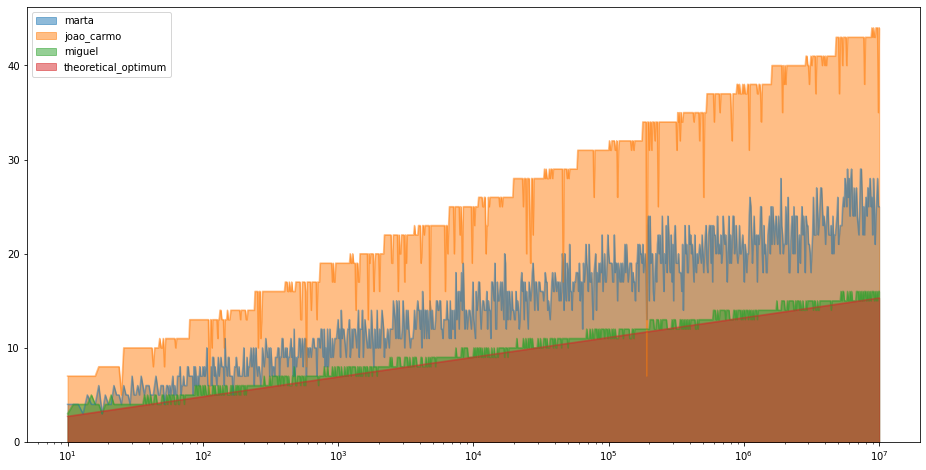

In [9]:
from math import log

df["theoretical_optimum"] = list(map(lambda x: log(2 * x, 3), df.index))
df.plot.area(figsize=(16, 8), stacked=False, logx=True).figure.savefig("results.png")